In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import sys, os, subprocess, glob, shutil
import cartopy
import cartopy.crs as ccrs
from pyproj import CRS
from datetime import datetime, timedelta
import xarray as xr
import pandas as pd
from scipy import stats
import warnings
import cartopy.feature as cfeature
from shapely import geometry
from shapely.geometry import Polygon
import matplotlib.dates as mdates

import cartopy.feature as cfeature


### It can be useful to estimate the area of each grid cell as well as the distance between two of them. Let's assume Earth is a sphere and grid cells are rectangulars.
def distance_on_unit_sphere(lat1, long1, lat2, long2):
    # Convert latitude and longitude to spherical coordinates in radians
    degrees_to_radians = np.pi / 180.0
    phi1 = (90.0 - lat1) * degrees_to_radians
    phi2 = (90.0 - lat2) * degrees_to_radians
    theta1 = long1 * degrees_to_radians
    theta2 = long2 * degrees_to_radians
    # Compute spherical distance
    cos = (np.sin(phi1) * np.sin(phi2) * np.cos(theta1 - theta2) +
           np.cos(phi1) * np.cos(phi2))
    arc = np.arccos(np.clip(cos, -1.0, 1.0))  # Clip to avoid numerical issues

    return arc

# Suppress the specific RuntimeWarning from shapely. This is an annoying problem with neXtSIM-Ant because of the gridding, so we just suppress these because they don't affect the visualizations
warnings.filterwarnings("ignore", category=RuntimeWarning, 
                       module="shapely.constructive")
warnings.filterwarnings("ignore", category=RuntimeWarning, 
                       module="shapely.predicates")
warnings.filterwarnings("ignore", category=RuntimeWarning, 
                       module="shapely.set_operations")
def compute_area(lons_nxsim, lats_nxsim):
    nx = lons_nxsim.shape[1]
    ny = lons_nxsim.shape[0]
    dx = np.zeros_like(lons_nxsim)
    dy = np.zeros_like(lons_nxsim)

    R = 6370997  # Earth radius in meters

    # Compute dx (north-south distances)
    dx[:-1, :] = distance_on_unit_sphere(
        lats_nxsim[:-1, :], lons_nxsim[:-1, :],
        lats_nxsim[1:, :], lons_nxsim[1:, :]
    ) * R

    # Compute dy (east-west distances)
    dy[:, :-1] = distance_on_unit_sphere(
        lats_nxsim[:, :-1], lons_nxsim[:, :-1],
        lats_nxsim[:, 1:], lons_nxsim[:, 1:]
    ) * R

    # Fill last row and column
    dx[-1, :] = dx[-2, :]
    dy[:, -1] = dy[:, -2]

    # Compute area
    area = dx * dy
    return area

# Create a Cartopy Stereographic projection with your custom parameters
proj_ANT = ccrs.Stereographic(
    central_latitude=-90.0,
    central_longitude=0,
    true_scale_latitude=-60.0,
    globe=ccrs.Globe(semimajor_axis=6378273.0, semiminor_axis=6356889.448910593)
)

proj_weddell = ccrs.AzimuthalEquidistant(
    central_latitude=-75.0,
    central_longitude=-166,
    globe=ccrs.Globe(semimajor_axis=6378273.0, semiminor_axis=6356889.448910593)
)

def format_timeseries():
    plt.grid(ls="--",lw=0.25)
    plt.legend()

def Antarctic_plot(lat, lon, data, ax, vmin, vmax, cmap=None, title=None):
    # This is a placeholder - replace with your actual Antarctic_plot function
    # but with these enhancements:
    im = ax.pcolormesh(lon, lat, data, transform=ccrs.PlateCarree(), 
                      vmin=vmin, vmax=vmax, cmap=cmap)
    
    # Add coastlines with higher resolution
    ax.coastlines(resolution='50m', color='black', linewidth=0.8)
    
    # Add grid lines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    
    # Add land features
    ax.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='black', zorder=0)
    
    # Add a fancy title
    if title:
        ax.set_title(title, fontsize=12, fontweight='bold')
        
    # Safely add land feature with buffer handling
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning, 
                               message="invalid value encountered in buffer")
    
    return im, ax

The above code came thanks to Guillaume Boutin. You will look at code related to wavewatch 3 and neXtSIM output next!

In [2]:
nextsim_folder = "../neXtSIM-Antarctic/"
BBM_folder = nextsim_folder + 'BBM/'
EVP_folder = nextsim_folder + 'MEVP/'

BBM_files = f"{BBM_folder}Moorings_%Ym%m.nc" ## One file per month contains all variables
EVP_files = f"{EVP_folder}Moorings_%Ym%m.nc" ## One file per month contains all variables

In [3]:
### Pick your favourite year/month (among what is available)
date_specific = datetime(2016,7,5,21,00,00) 

### The name of the corresponding file
BBM_file = date_specific.strftime(BBM_files)
EVP_file = date_specific.strftime(EVP_files)
print(f"\nWe are looking at {date_specific.month}/{date_specific.day}/{date_specific.year} and found ... \n{BBM_file} for BBM data \n{EVP_file} for our EVP data \n")

### We could check whether it exists first, but the error in open_dataset would tell us if this is not the case anyway.
ds_bbm = xr.open_dataset(BBM_file)
ds_evp = xr.open_dataset(EVP_file)
# print(list(ds_evp.keys()))




We are looking at 7/5/2016 and found ... 
../neXtSIM-Antarctic/BBM/Moorings_2016m07.nc for BBM data 
../neXtSIM-Antarctic/MEVP/Moorings_2016m07.nc for our EVP data 



Let's look at differences in SIC between the two at this point in time

In [4]:
time_str = date_specific.strftime('%d %b %Y %H:%M')
# This gives us a period we are concerned with ice changing
time_end = date_specific + timedelta(days=7)
time_period = f"{date_specific.strftime('%d %b')} - {time_end.strftime('%d %b %Y')}"

# Antarctic overview
Ant_loc = [-180,180,-90,-60]; 
# We will focus on the Weddell Sea
Weddell_loc = [-50, 0, -80, -60]

lat_vals = ds_bbm['latitude']
lon_vals = ds_bbm['longitude']
grid_area=compute_area(ds_bbm["longitude"],ds_bbm["latitude"]) / 1e6 #converting to km2
grid_area_da = xr.DataArray(grid_area, coords={"y": ds_bbm.y, "x": ds_bbm.x}, dims=("y", "x"))

In [5]:
# Calculate SIC and differences. Focus on areas where there is near-100% SIC in advance
bbm_sic = ds_bbm['sic'].sel(time=slice(date_specific, time_end))
evp_sic = ds_evp['sic'].sel(time=slice(date_specific, time_end))

diff_sic = bbm_sic - evp_sic

# We want to include where we have super-high SIC in either one. 
diff_sic = diff_sic.where(np.logical_or(evp_sic > 0.99, bbm_sic > 0.99), np.nan)


# Calculate kinetic energy (velocity squared)
bbm_ke = np.power(ds_bbm['siu'].sel(time=slice(date_specific, time_end)), 2) + \
            np.power(ds_bbm['siv'].sel(time=slice(date_specific, time_end)), 2)
evp_ke = np.power(ds_evp['siu'].sel(time=slice(date_specific, time_end)), 2) + \
            np.power(ds_evp['siv'].sel(time=slice(date_specific, time_end)), 2)
diff_ke = bbm_ke - evp_ke
diff_ke = diff_ke.where(np.logical_or(evp_sic > 0.99, bbm_sic > 0.99), np.nan)

# Get new ice formation through the entire period of the storm we are considering
bbm_newice = ds_bbm['newice'].sel(time=slice(date_specific, time_end))
evp_newice = ds_evp['newice'].sel(time=slice(date_specific, time_end))
diff_newice = bbm_newice - evp_newice
diff_newice = diff_newice.where(np.logical_or(evp_sic > 0.99, bbm_sic > 0.99), np.nan)


In [6]:
# Some plotting things
# Define custom colormaps
sic_cmap = plt.cm.Blues  # Blues colormap for sea ice concentration
diff_cmap = plt.cm.RdBu_r  # Red-Blue diverging colormap for differences
ke_cmap = plt.cm.viridis  # Viridis colormap for kinetic energy
growth_cmap = plt.cm.viridis
# Create GridSpec with less padding
gs = gridspec.GridSpec(2, 3, 
                      height_ratios=[1, 0.05],  # Keep the same ratio
                      width_ratios=[1, 1, 1],
                      hspace=0.1,  # Reduce vertical space between plots and colorbars
                      wspace=0.1,  # Reduce horizontal space between plots
                      top=0.9)    

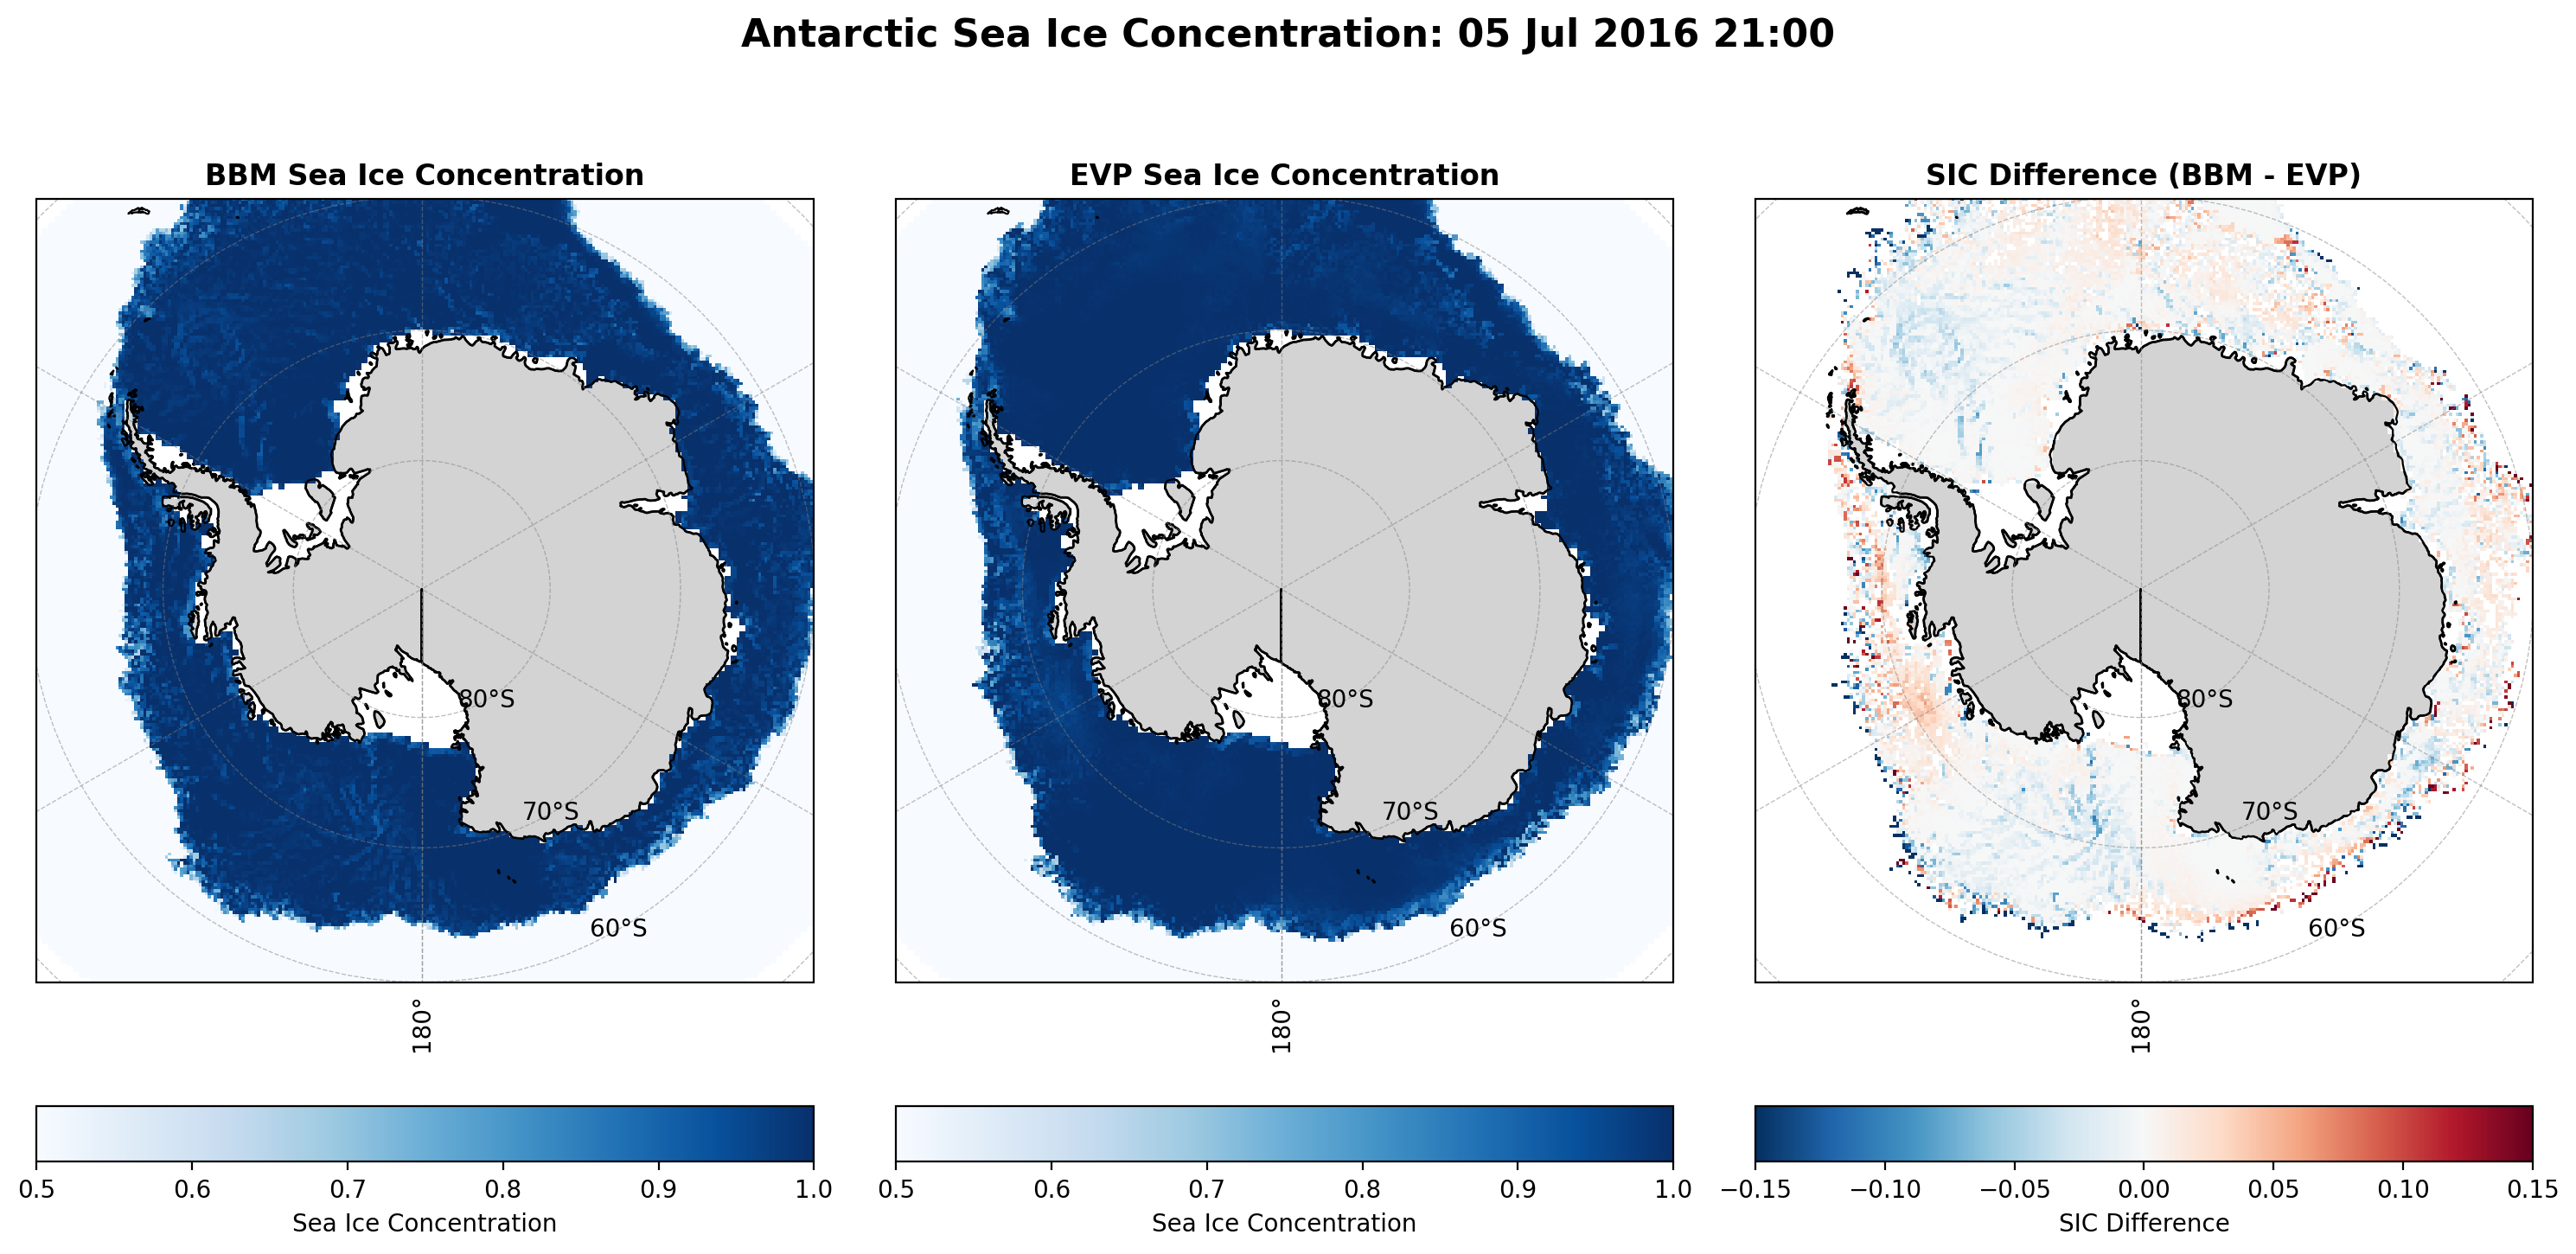

In [7]:

# Create figure with better layout using GridSpec
fig = plt.figure(figsize=(15, 8), dpi=200)
gs = gridspec.GridSpec(2, 3, height_ratios=[1, 0.05], width_ratios=[1, 1, 1])




# Create the three map plots
ax1 = fig.add_subplot(gs[0, 0], projection=proj_ANT)
im1, ax1 = Antarctic_plot(lat_vals, lon_vals, bbm_sic.isel(time=0), ax1, 0.5, 1, 
                                  cmap=sic_cmap, title='BBM Sea Ice Concentration')
ax1.set_extent(Ant_loc, crs=ccrs.PlateCarree())

ax2 = fig.add_subplot(gs[0, 1], projection=proj_ANT)
im2, ax2 = Antarctic_plot(lat_vals, lon_vals, evp_sic.isel(time=0), ax2, 0.5, 1, 
                                  cmap=sic_cmap, title='EVP Sea Ice Concentration')
ax2.set_extent(Ant_loc, crs=ccrs.PlateCarree())

ax3 = fig.add_subplot(gs[0, 2], projection=proj_ANT)
im3, ax3 = Antarctic_plot(lat_vals, lon_vals, diff_sic.isel(time=0), ax3, -0.15, 0.15, 
                                  cmap=diff_cmap, title='SIC Difference (BBM - EVP)')
ax3.set_extent(Ant_loc, crs=ccrs.PlateCarree())

# Add colorbars
cax1 = fig.add_subplot(gs[1, 0])
cbar1 = plt.colorbar(im1, cax=cax1, orientation='horizontal')
cbar1.set_label('Sea Ice Concentration', fontsize=10)

cax2 = fig.add_subplot(gs[1, 1])
cbar2 = plt.colorbar(im2, cax=cax2, orientation='horizontal')
cbar2.set_label('Sea Ice Concentration', fontsize=10)

cax3 = fig.add_subplot(gs[1, 2])
cbar3 = plt.colorbar(im3, cax=cax3, orientation='horizontal')
cbar3.set_label('SIC Difference', fontsize=10)

# Add a super title for the entire figure
plt.suptitle(f'Antarctic Sea Ice Concentration: {time_str}', 
             fontsize=16, y=0.9, fontweight='bold')

# Don't use tight_layout as it can override our custom spacing
# Instead, use subplots_adjust for fine control
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.9)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save figure with high quality
# plt.savefig('enhanced_antarctic_sea_ice_concentration.png', dpi=300, bbox_inches='tight')

# Show plot
plt.show()

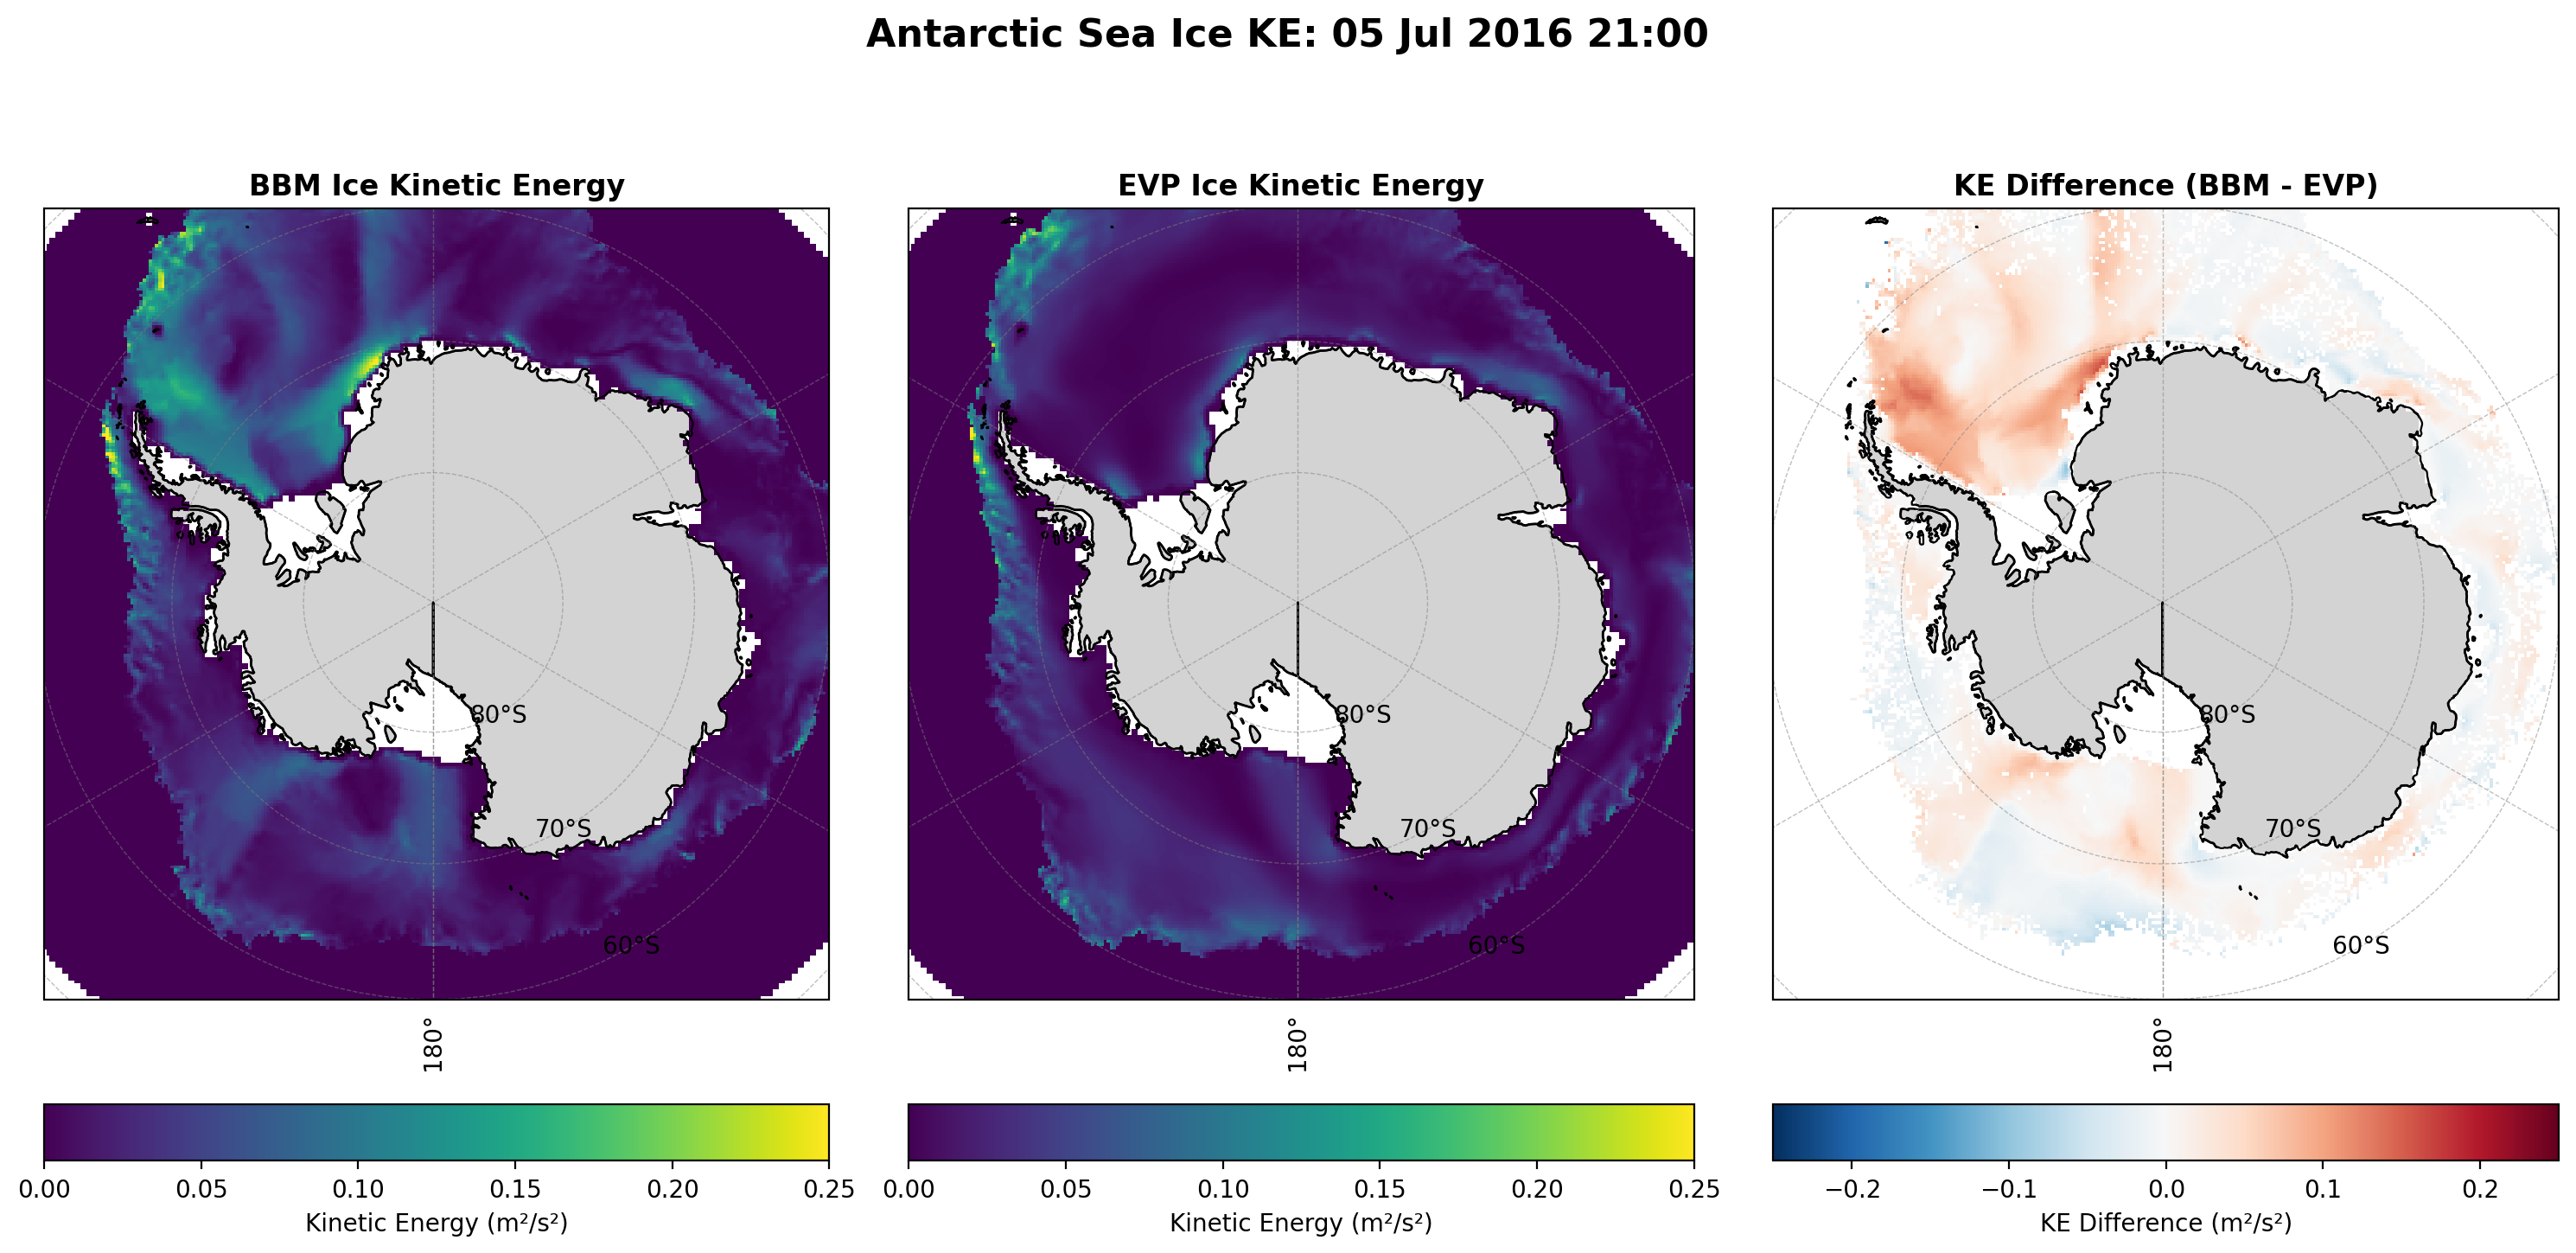

In [8]:
# Create figure with better layout using GridSpec
fig = plt.figure(figsize=(15, 8), dpi=200)

# Create the three map plots
ax1 = fig.add_subplot(gs[0, 0], projection=proj_ANT)
im1, ax1 = Antarctic_plot(lat_vals, lon_vals, bbm_ke.isel(time=0), ax1, 0, 0.25, 
                                  cmap=ke_cmap, title='BBM Ice Kinetic Energy')
ax1.set_extent(Ant_loc, crs=ccrs.PlateCarree())

ax2 = fig.add_subplot(gs[0, 1], projection=proj_ANT)
im2, ax2 = Antarctic_plot(lat_vals, lon_vals, evp_ke.isel(time=0), ax2, 0, 0.25, 
                                  cmap=ke_cmap, title='EVP Ice Kinetic Energy')
ax2.set_extent(Ant_loc, crs=ccrs.PlateCarree())

ax3 = fig.add_subplot(gs[0, 2], projection=proj_ANT)
im3, ax3 = Antarctic_plot(lat_vals, lon_vals, diff_ke.isel(time=0), ax3, -.25, .25, 
                                  cmap=diff_cmap, title='KE Difference (BBM - EVP)')
ax3.set_extent(Ant_loc, crs=ccrs.PlateCarree())

# Add colorbars
cax1 = fig.add_subplot(gs[1, 0])
cbar1 = plt.colorbar(im1, cax=cax1, orientation='horizontal')
cbar1.set_label('Kinetic Energy (m²/s²)', fontsize=10)

cax2 = fig.add_subplot(gs[1, 1])
cbar2 = plt.colorbar(im2, cax=cax2, orientation='horizontal')
cbar2.set_label('Kinetic Energy (m²/s²)', fontsize=10)

cax3 = fig.add_subplot(gs[1, 2])
cbar3 = plt.colorbar(im3, cax=cax3, orientation='horizontal')
cbar3.set_label('KE Difference (m²/s²)', fontsize=10)

# Add a super title for the entire figure
plt.suptitle(f'Antarctic Sea Ice KE: {time_str}', 
             fontsize=16, y=0.9, fontweight='bold')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save figure with high quality
# plt.savefig('enhanced_antarctic_sea_ice_kinetic_energy.png', dpi=300, bbox_inches='tight')

# Show plot
plt.show()

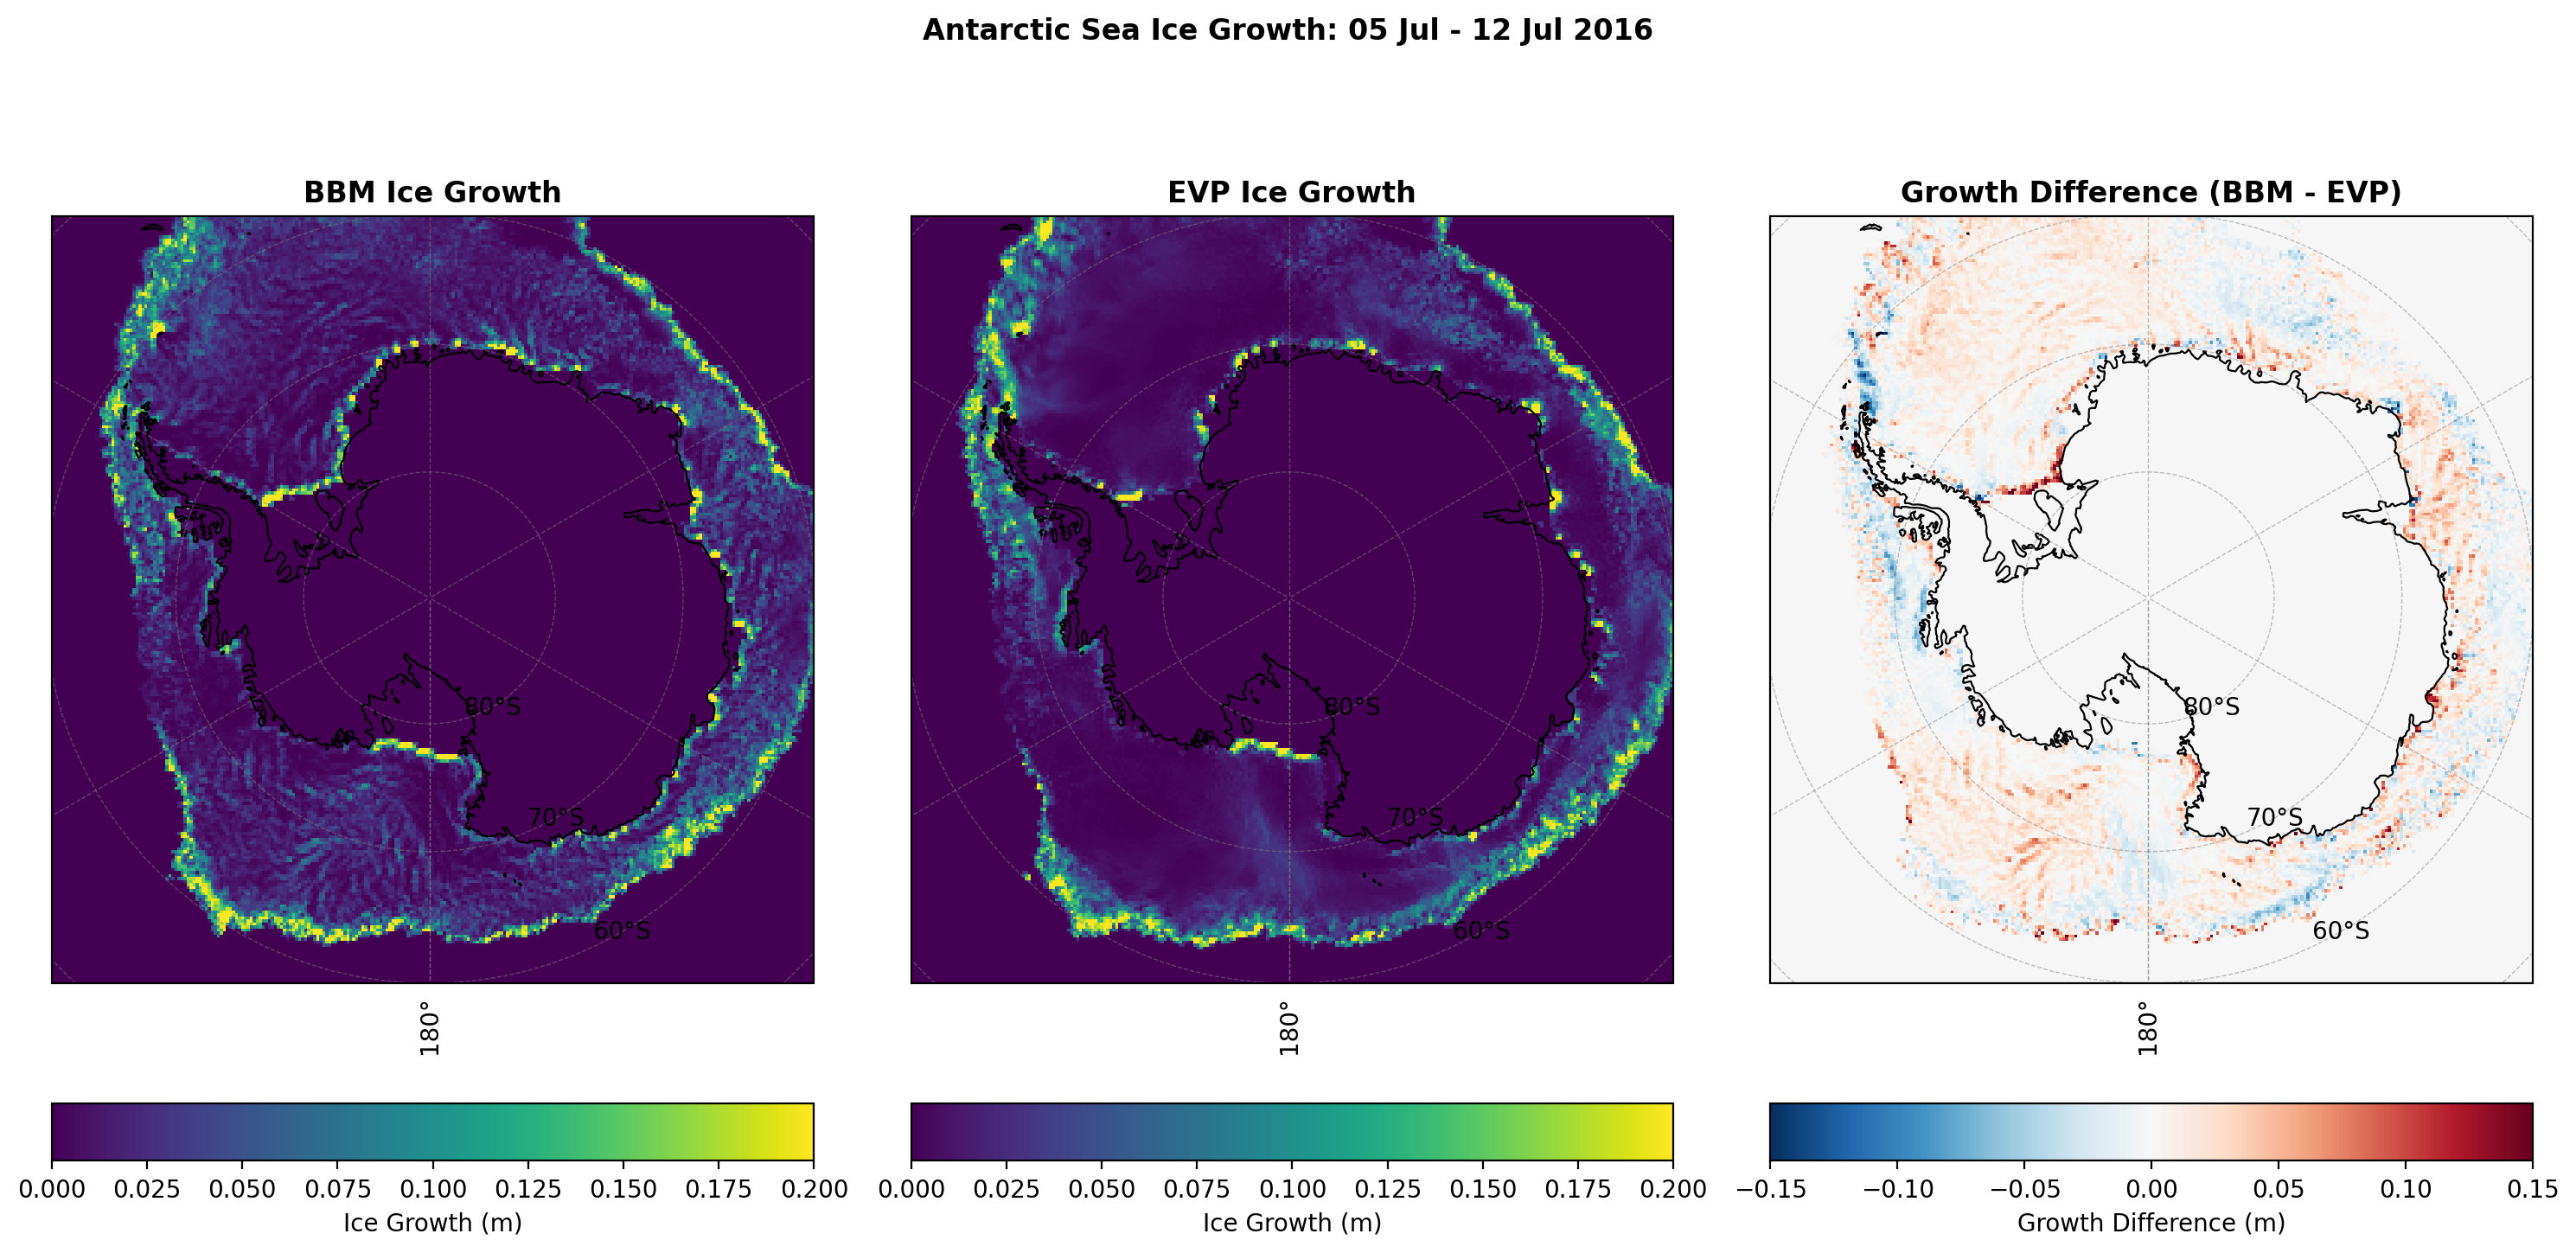

In [15]:
# Time selection

# Create figure with better layout using GridSpec
fig = plt.figure(figsize=(15, 8), dpi=200)

# Create the three map plots
ax1 = fig.add_subplot(gs[0, 0], projection=proj_ANT)
im1, ax1 = Antarctic_plot(lat_vals, lon_vals, bbm_newice.sum(dim='time'), ax1, 0, 0.2, 
                                  cmap=growth_cmap, title='BBM Ice Growth')
ax1.set_extent(Ant_loc, crs=ccrs.PlateCarree())

ax2 = fig.add_subplot(gs[0, 1], projection=proj_ANT)
im2, ax2 = Antarctic_plot(lat_vals, lon_vals, evp_newice.sum(dim='time'), ax2, 0, 0.2, 
                                  cmap=growth_cmap, title='EVP Ice Growth')
ax2.set_extent(Ant_loc, crs=ccrs.PlateCarree())

ax3 = fig.add_subplot(gs[0, 2], projection=proj_ANT)
im3, ax3 = Antarctic_plot(lat_vals, lon_vals, diff_newice.sum(dim='time'), ax3, -0.15, 0.15, 
                                  cmap=diff_cmap, title='Growth Difference (BBM - EVP)')
ax3.set_extent(Ant_loc, crs=ccrs.PlateCarree())

# Add colorbars
cax1 = fig.add_subplot(gs[1, 0])
cbar1 = plt.colorbar(im1, cax=cax1, orientation='horizontal')
cbar1.set_label('Ice Growth (m)', fontsize=10)

cax2 = fig.add_subplot(gs[1, 1])
cbar2 = plt.colorbar(im2, cax=cax2, orientation='horizontal')
cbar2.set_label('Ice Growth (m)', fontsize=10)

cax3 = fig.add_subplot(gs[1, 2])
cbar3 = plt.colorbar(im3, cax=cax3, orientation='horizontal')
cbar3.set_label('Growth Difference (m)', fontsize=10)

# Add a super title for the entire figure
plt.suptitle(f'Antarctic Sea Ice Growth: {time_period}', 
             fontsize=12, y=0.9, fontweight='bold')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show plot
plt.show()

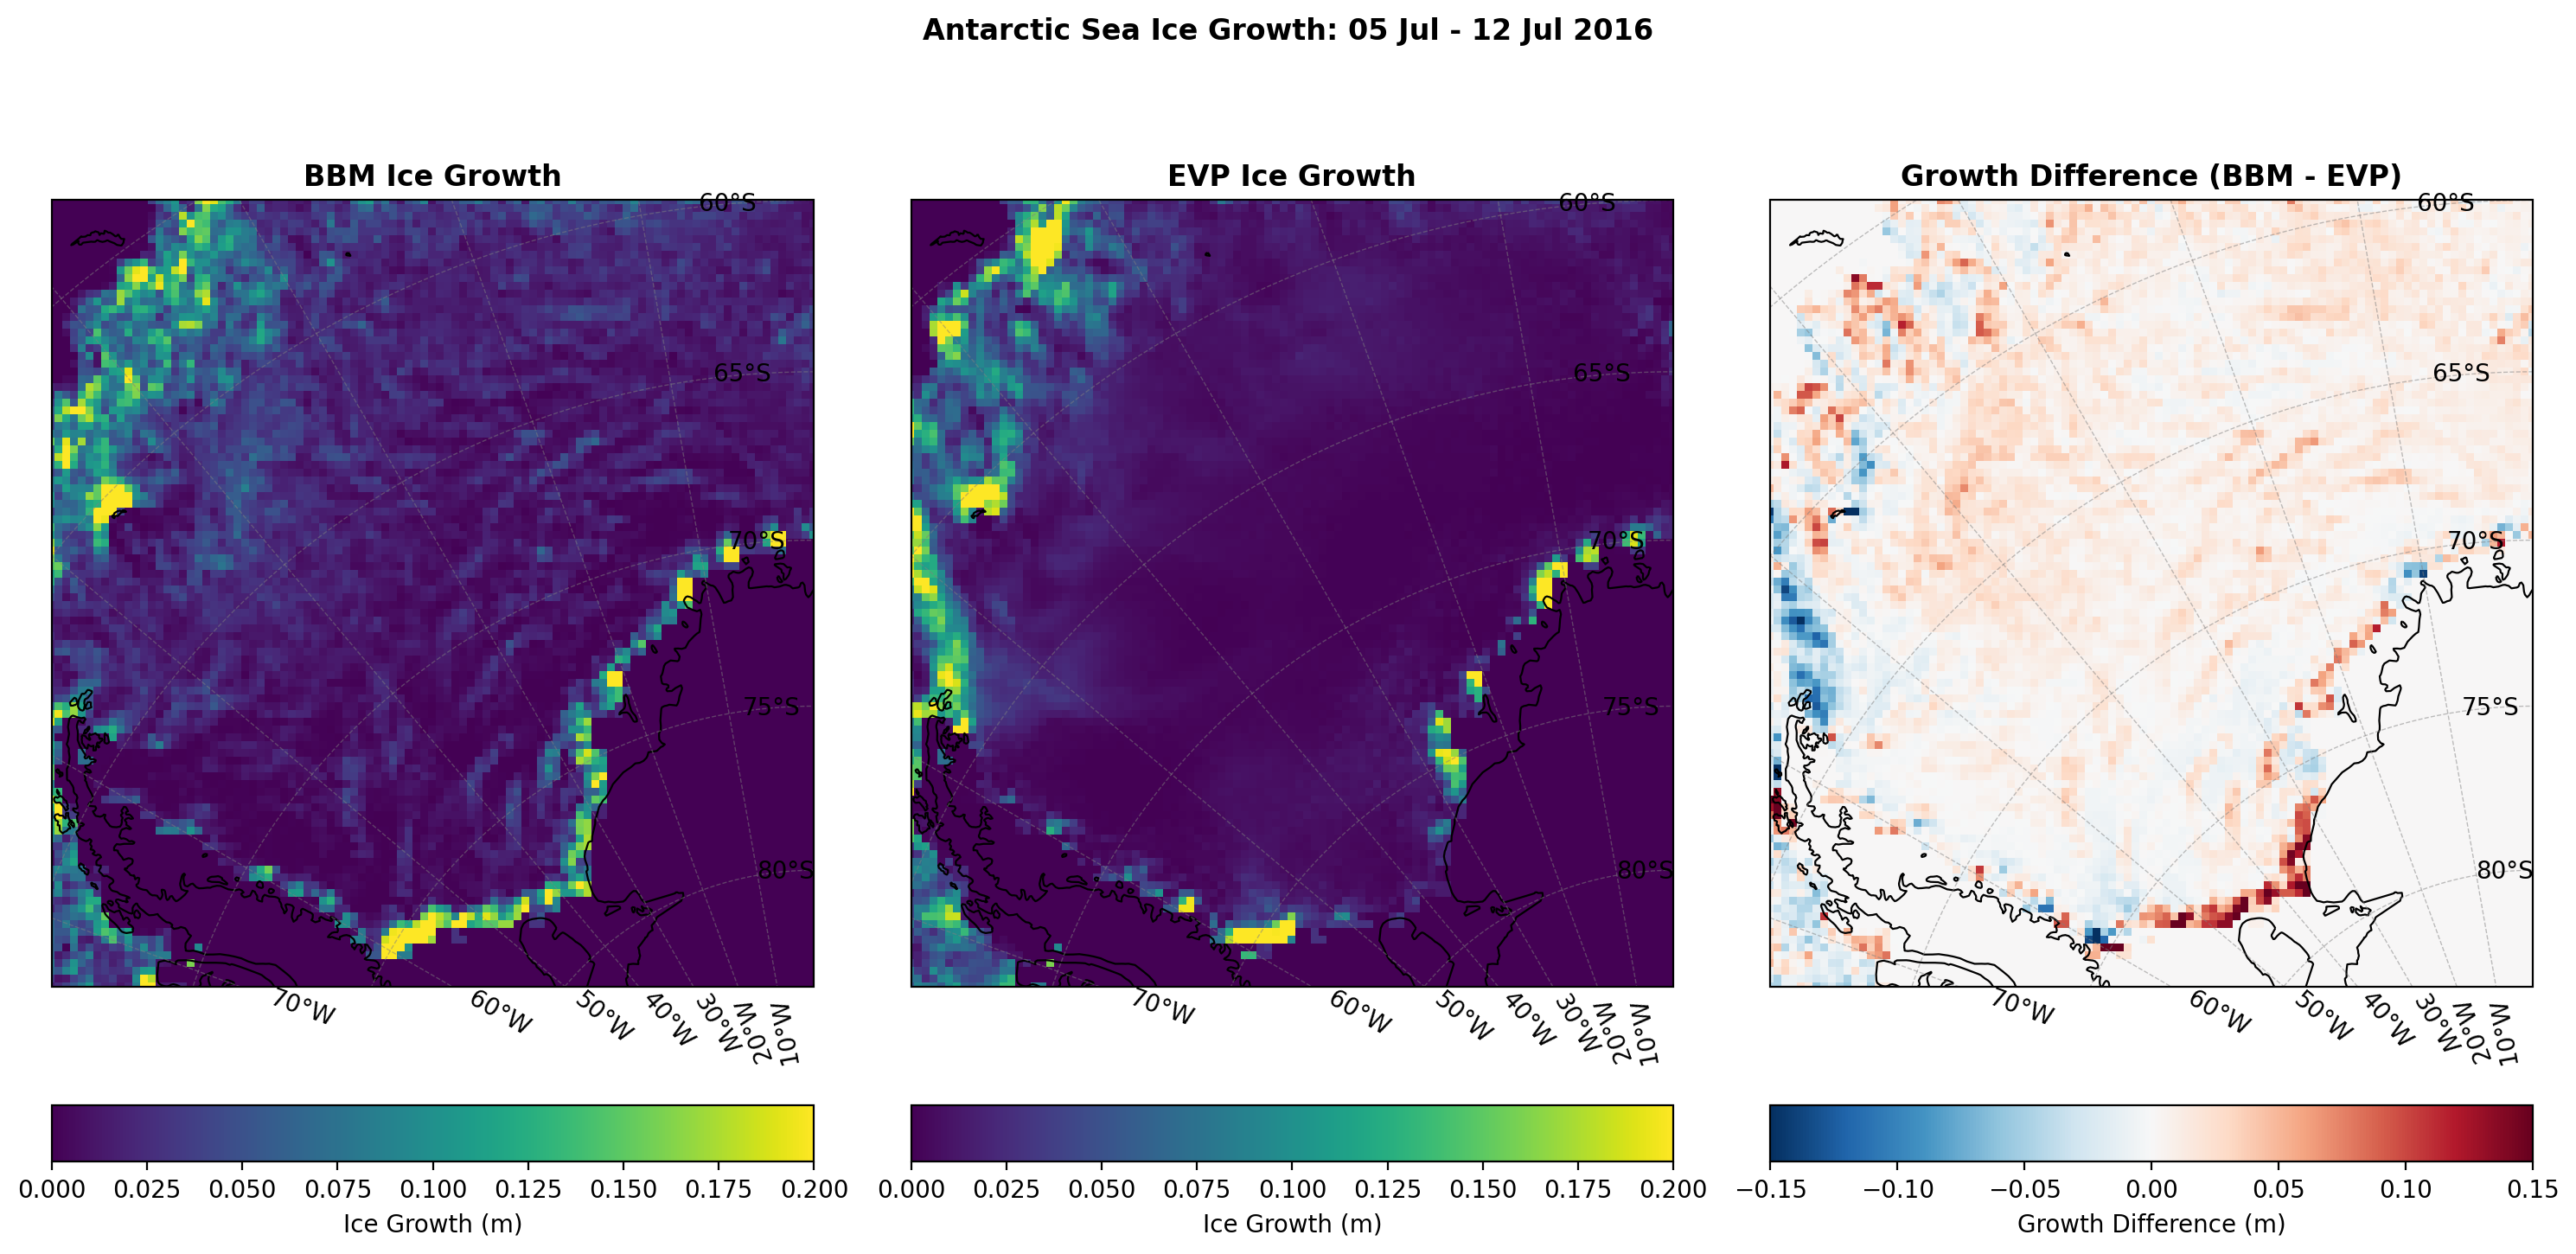

In [16]:
# Time selection

# Create figure with better layout using GridSpec
fig = plt.figure(figsize=(15, 8), dpi=200)

# Create the three map plots
ax1 = fig.add_subplot(gs[0, 0], projection=proj_ANT)
im1, ax1 = Antarctic_plot(lat_vals, lon_vals, bbm_newice.sum(dim='time'), ax1, 0, 0.2, 
                                  cmap=growth_cmap, title='BBM Ice Growth')
ax1.set_extent(Weddell_loc, crs=ccrs.PlateCarree())

ax2 = fig.add_subplot(gs[0, 1], projection=proj_ANT)
im2, ax2 = Antarctic_plot(lat_vals, lon_vals, evp_newice.sum(dim='time'), ax2, 0, 0.2, 
                                  cmap=growth_cmap, title='EVP Ice Growth')
ax2.set_extent(Weddell_loc, crs=ccrs.PlateCarree())

ax3 = fig.add_subplot(gs[0, 2], projection=proj_ANT)
im3, ax3 = Antarctic_plot(lat_vals, lon_vals, diff_newice.sum(dim='time'), ax3, -0.15, 0.15, 
                                  cmap=diff_cmap, title='Growth Difference (BBM - EVP)')
ax3.set_extent(Weddell_loc, crs=ccrs.PlateCarree())

# Add colorbars
cax1 = fig.add_subplot(gs[1, 0])
cbar1 = plt.colorbar(im1, cax=cax1, orientation='horizontal')
cbar1.set_label('Ice Growth (m)', fontsize=10)

cax2 = fig.add_subplot(gs[1, 1])
cbar2 = plt.colorbar(im2, cax=cax2, orientation='horizontal')
cbar2.set_label('Ice Growth (m)', fontsize=10)

cax3 = fig.add_subplot(gs[1, 2])
cbar3 = plt.colorbar(im3, cax=cax3, orientation='horizontal')
cbar3.set_label('Growth Difference (m)', fontsize=10)

# Add a super title for the entire figure
plt.suptitle(f'Antarctic Sea Ice Growth: {time_period}', 
             fontsize=12, y=0.9, fontweight='bold')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show plot
plt.show()

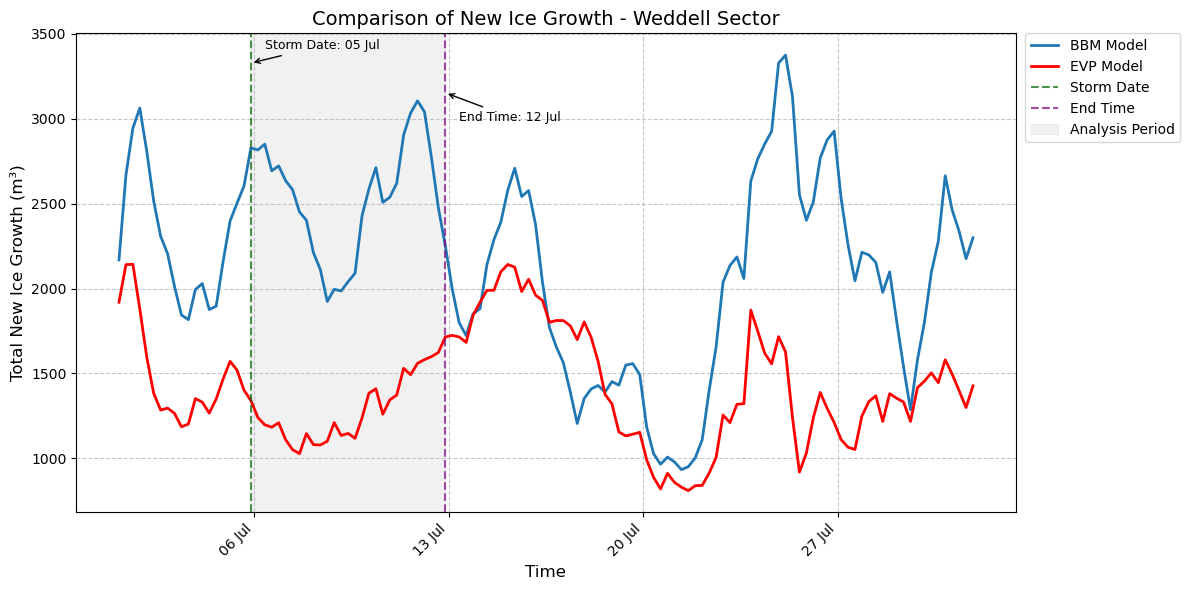

In [18]:
# Define the bounds for latitude and longitude
lat_min, lat_max = Weddell_loc[2], Weddell_loc[3]  # Assuming Ant_loc[2] and Ant_loc[3] are latitude bounds
lon_min, lon_max = Weddell_loc[0], Weddell_loc[1]  # Assuming Ant_loc[0] and Ant_loc[1] are longitude bounds

# Create masks for the regions within the specified bounds
lat_mask = (ds_bbm['latitude'] >= lat_min) & (ds_bbm['latitude'] <= lat_max)
lon_mask = (ds_bbm['longitude'] >= lon_min) & (ds_bbm['longitude'] <= lon_max)
combined_mask = lat_mask & lon_mask

region_lat = ds_bbm['latitude'].where(combined_mask, drop=True)
region_lon = ds_bbm['longitude'].where(combined_mask, drop=True)
region_area = grid_area_da.where(combined_mask, drop=True)

# Apply the mask to select the data within the bounds
region_bbm = ds_bbm['newice'].where(combined_mask, drop=True)
region_evp = ds_evp['newice'].where(combined_mask, drop=True)

# Create a more attractive figure with proper sizing
plt.figure(figsize=(12, 6))

# Plot the sum of the product with better styling
plt.plot(ds_bbm['time'], (region_area * region_bbm).sum(dim=['x', 'y']), 
         linewidth=2, label='BBM Model')
plt.plot(ds_bbm['time'], (region_area * region_evp).sum(dim=['x', 'y']), 
         color='red', linewidth=2, label='EVP Model')

# Add vertical lines for date_specific and time_end
plt.axvline(x=date_specific, color='darkgreen', linestyle='--', linewidth=1.5, 
           label='Storm Date', alpha=0.7)
plt.axvline(x=time_end, color='purple', linestyle='--', linewidth=1.5, 
           label='End Time', alpha=0.7)

# Add shaded region between the two dates
plt.axvspan(date_specific, time_end, color='lightgray', alpha=0.3, label='Analysis Period')

# Set major ticks every two weeks
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7)) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))  # Day and month format

# Rotate date labels for better readability
plt.gcf().autofmt_xdate(rotation=45)

# Add labels and title
plt.xlabel('Time', fontsize=12)
plt.ylabel('Total New Ice Growth (m³)', fontsize=12)
plt.title('Comparison of New Ice Growth - Weddell Sector', fontsize=14)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Add legend with better positioning
plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1), borderaxespad=0)

# Annotate the specific dates
plt.annotate(f'Storm Date: {date_specific.strftime("%d %b")}', 
            xy=(date_specific, plt.ylim()[1]*0.95),
            xytext=(10, 10),
            textcoords='offset points',
            arrowprops=dict(arrowstyle='->'),
            fontsize=9)

plt.annotate(f'End Time: {time_end.strftime("%d %b")}', 
            xy=(time_end, plt.ylim()[1]*0.9),
            xytext=(10, -20),
            textcoords='offset points',
            arrowprops=dict(arrowstyle='->'),
            fontsize=9)

# Tight layout to ensure everything fits nicely
plt.tight_layout()

# Show the plot
plt.show()